In [1]:
#Importing libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
from pandas import concat
from numpy import asarray
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime
from statsmodels.tsa.tsatools import lagmat
from statsmodels.tsa.arima.model import ARIMA

# Data Import and Cleaning

In [2]:
%store -r df_cleaned

In [3]:
df = df_cleaned 

In [4]:
TS1 = df[(df['Plz'] == "['25', '24']")]
TS1_A2 = TS1[TS1['full'] == 'A2 -  geschreddert']
TS1_A1A2 = TS1[TS1['full'] == 'A1 & A2 -  geschreddert']
TS1_A2A3 = TS1[TS1['full'] == 'A2 & A3 -  geschreddert']

In [5]:
splitratio = 0.05
nobs = round(len(TS1_A1A2)*splitratio)
df_train, df_test = TS1_A1A2[0:-nobs], TS1_A1A2[-nobs:]

## Decision Tree

### Walk-forward

In [6]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 n_vars = 1 if type(data) is list else data.shape[1]
 df = pd.DataFrame(data)
 cols = list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
    cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
# drop rows with NaN values
 if dropnan:
    agg.dropna(inplace=True)
 return agg.values

In [7]:
X = TS1_A1A2["wPreis"].values.reshape(-1, 1)
dt_data = series_to_supervised(X, n_in=4)

In [8]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
 return data[:-n_test, :], data[-n_test:, :]

In [9]:
from sklearn.tree import DecisionTreeRegressor


In [10]:
# walk-forward validation for univariate data
def dt_walk_forward_validation(data, n_test):
 predictions = list()
 direction_accuracies = list() 
 # split dataset
 train, test = train_test_split(data, n_test)
 # seed history with training dataset
 history = [x for x in train]
 # step over each time-step in the test set
 for i in range(len(test)):
    # split test row into input and output columns
    testX, testy = test[i, :-1], test[i, -1]
    # fit model on history and make a prediction
    yhat = decision_tree_forecast(history, testX)
    # store forecast in list of predictions
    predictions.append(yhat)
    if i > 0:  # Direction accuracy is not applicable for the first prediction
            forecast_diff = yhat - predictions[-2]
            actual_diff = testy - test[i - 1, -1]
            direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
            direction_accuracies.append(direction_accuracy)
    # add actual observation to history for the next loop
    history.append(test[i])
    # summarize progress
    # print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
 # estimate prediction error
 mae = mean_absolute_error(test[:, -1], predictions)
 me = np.mean(predictions - test[:, -1])  # Mean Error
 rmse = mean_squared_error(test[:, -1], predictions, squared=False)
 overall_direction_accuracy = np.mean(direction_accuracies)

 return {'mae':mae, 'me': me, 'rmse': rmse, 'expected':test[:, -1], 'predictions': predictions, 'direction_accuracy': overall_direction_accuracy}

# return error, me, rmse ,test[:, -1], predictions, overall_direction_accuracy 

In [11]:
# fit an random forest model and make a one step prediction
def decision_tree_forecast(train, testX):
 # transform list into array
 train = asarray(train)
 # split into input and output columns
 trainX, trainy = train[:, :-1], train[:, -1]
 # fit model
 model = DecisionTreeRegressor(random_state=42)
 model.fit(trainX, trainy)
 # make a one-step prediction
 yhat = model.predict([testX])
 #print(yhat)
 return yhat[0]

In [12]:
def adjust(val, length= 6): return str(val).ljust(length) # length
print('Decision Tree Walk-forward forecast Accuracy of: wPreis')
wf_accuracy_prod = dt_walk_forward_validation(dt_data, 6)
# for k, v in wf_accuracy_prod.items():
#     print(adjust(k), ': ', round(v,4))

Decision Tree Walk-forward forecast Accuracy of: wPreis


MAE: 7.835
ME: 1.156
RMSE: 9.811
Direction Accuracy: 0.600


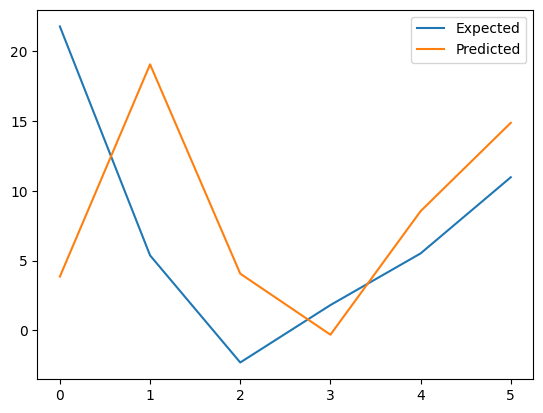

In [13]:
mae = wf_accuracy_prod['mae']
me = wf_accuracy_prod['me']
rmse = wf_accuracy_prod['rmse']
expected = wf_accuracy_prod['expected']
predictions = wf_accuracy_prod['predictions']
direction_accuracy = wf_accuracy_prod['direction_accuracy']

# evaluate
# mae, me, rmse, y, yhat, direction_accuracy = dt_walk_forward_validation(dt_data, 6)
print('MAE: %.3f' % mae)
print('ME: %.3f' % me)
print('RMSE: %.3f' % rmse)
print('Direction Accuracy: %.3f' % direction_accuracy)
# plot expected vs preducted
plt.plot(expected, label='Expected')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

In [14]:
results = {
    'mae': [mae],
    'me': [me],
    'rmse': [rmse],
    'direction_accuracy': [direction_accuracy]
}

# Convert the dictionary into a DataFrame
DecisionTree_wf = pd.DataFrame(results)
DecisionTree_wf

,mae,me,rmse,direction_accuracy
0,7.835223,1.155846,9.811467,0.6


In [15]:
%store DecisionTree_wf


Stored 'DecisionTree_wf' (DataFrame)


### Rolling forecast for Decision Tree

Since this method uses 4 lagged values as input for predicting the next step, we are exposing the test data set in every iteration. So essentially this is a forecast with a window of "input" moving along the test set, predicting one step at a time, but having been trained on the original training set only once.

In [16]:
train, test = train_test_split(dt_data, nobs)
train = asarray(train)
trainX, trainy = train[:, :-1], train[:, -1]


In [17]:
model_dt_rolling = DecisionTreeRegressor(random_state=42, max_depth = 3)
model_dt_rolling.fit(trainX, trainy)

DecisionTreeRegressor(max_depth=3, random_state=42)

In [18]:
predictions = list()
direction_accuracies = list() 

In [19]:
for i in range(len(test)):
    # split test row into input and output columns
    testX, testy = test[i, :-1], test[i, -1]
    # ONLY MAKE ONE-STEP PREDICTIONS BASED ON MODEL TRAINED ONCE 
    print([testX])
    yhat = model_dt_rolling.predict([testX])
    # store forecast in list of predictions
    predictions.append(yhat[0])
    if i > 0:  # Direction accuracy is not applicable for the first prediction
            forecast_diff = yhat - predictions[-2]
            actual_diff = testy - test[i - 1, -1]
            direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
            direction_accuracies.append(direction_accuracy)
    # summarize progress
    print('>expected=%.1f, predicted=%.1f' % (testy, yhat))


[array([14.94494128, 13.7571362 , 17.34321268, 19.08385688])]
>expected=22.2, predicted=23.3
[array([13.7571362 , 17.34321268, 19.08385688, 22.15590367])]
>expected=14.1, predicted=23.3
[array([17.34321268, 19.08385688, 22.15590367, 14.05657364])]
>expected=5.7, predicted=9.5
[array([19.08385688, 22.15590367, 14.05657364,  5.70419682])]
>expected=21.8, predicted=9.5
[array([22.15590367, 14.05657364,  5.70419682, 21.77178067])]
>expected=5.4, predicted=23.3
[array([14.05657364,  5.70419682, 21.77178067,  5.37221127])]
>expected=-2.3, predicted=9.5
[array([ 5.70419682, 21.77178067,  5.37221127, -2.29737704])]
>expected=1.8, predicted=-0.8
[array([21.77178067,  5.37221127, -2.29737704,  1.8152799 ])]
>expected=5.5, predicted=9.5
[array([ 5.37221127, -2.29737704,  1.8152799 ,  5.51596431])]
>expected=11.0, predicted=9.5


MAE: 7.148
ME: 3.527
RMSE: 9.057
Direction Accuracy: 0.375


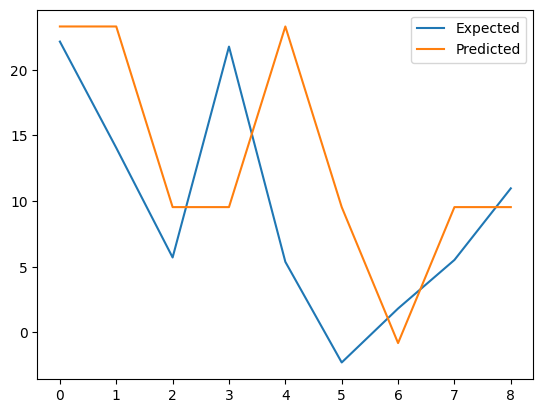

In [20]:
mae = mean_absolute_error(test[:, -1], predictions)
me = np.mean(predictions - test[:, -1])  # Mean Error
rmse = mean_squared_error(test[:, -1], predictions, squared=False)
overall_direction_accuracy = np.mean(direction_accuracies)

print('MAE: %.3f' % mae)
print('ME: %.3f' % me)
print('RMSE: %.3f' % rmse)
print('Direction Accuracy: %.3f' % overall_direction_accuracy)
# plot expected vs preducted
plt.plot(test[:, -1], label='Expected')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

In [21]:
roll_results = {
    'mae': [mae],
    'me': [me],
    'rmse': [rmse],
    'direction_accuracy': [overall_direction_accuracy]
}

# Convert the dictionary into a DataFrame
DecisionTree_roll = pd.DataFrame(roll_results)
DecisionTree_roll

,mae,me,rmse,direction_accuracy
0,7.148119,3.527439,9.056628,0.375


In [22]:
%store DecisionTree_roll

Stored 'DecisionTree_roll' (DataFrame)


## Static (Multi-step) Forecast

Since the above methods use the 4-week lagged values as inputs, it is not possible to use the same method to do static (multi-step) forecasting. For this, we will need to train the model on the original training dataset, not expose it to the test data set and ask it to predict for 6 steps ahead. 

This can be achieved using the ForecasterAutoreg class from the SKforecast package. This class turns any regressor compatible with the scikit-learn API into a recursive autoregressive (multi-step) forecaster.

In [23]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg

In [24]:
# Define the forecaster
forecaster = ForecasterAutoreg(
    # Add the sklearn regressor and lags
    regressor = DecisionTreeRegressor(random_state = 123),
    lags = 4
)

In [25]:
y_train = df_train['wPreis']

# Check if y_train is a pandas Series
# print(isinstance(y_train, pd.Series))  # Should print True

In [26]:
# Now you can pass y_train to forecaster.fit()
forecaster.fit(y=y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


In [27]:
# Predict the test period
predicted_test = forecaster.predict(steps = len(df_test))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:867: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


In [28]:
predicted_test

4     13.767914
5     17.343213
6     18.168432
7     13.767914
8     17.343213
9     18.168432
10    13.767914
11    17.343213
12    18.168432
Name: pred, dtype: float64

In [29]:
def forecast_accuracy(forecast, actual):
      mae = mean_absolute_error(actual, forecast) # MAE
      me = np.mean(forecast - actual)             # ME
      rmse = np.mean((forecast - actual)**2)**.5  # RMSE
      # Direction accuracy
      forecast_diff = np.diff(forecast)
      actual_diff = np.diff(actual)
      direction_accuracy = np.mean(np.sign(forecast_diff) == np.sign(actual_diff))
    
      return {'mae': mae, 'me': me, 'rmse': rmse, 'direction_accuracy': direction_accuracy}


In [30]:
predicted_test.index = df_test.index


Decision Tree Static Forecast Accuracy of: wPreis
mae    :  10.6173
me     :  6.9747
rmse   :  11.5339
direction_accuracy :  0.25


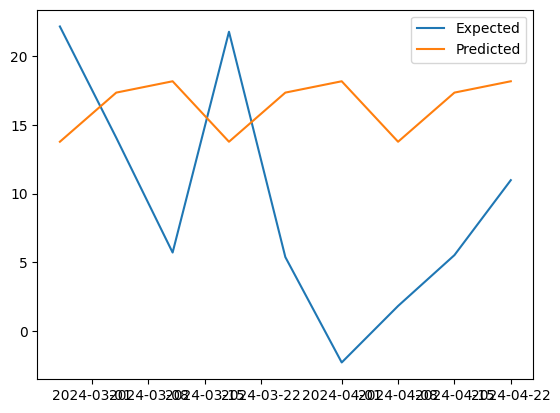

In [31]:
def adjust(val, length= 6): return str(val).ljust(length) # length
print('Decision Tree Static Forecast Accuracy of: wPreis')
stat_accuracy_prod = forecast_accuracy(predicted_test, df_test['wPreis'])
for k, v in stat_accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))


# plot expected vs preducted
plt.plot(df_test['wPreis'], label='Expected')
plt.plot(predicted_test, label='Predicted')
plt.legend()
plt.show()

In [32]:
DecisionTree_static = pd.DataFrame([stat_accuracy_prod])
DecisionTree_static



,mae,me,rmse,direction_accuracy
0,10.617329,6.974694,11.533878,0.25


In [33]:
%store DecisionTree_static

Stored 'DecisionTree_static' (DataFrame)


## All other clusters and categories 

In [34]:
def static_forecast(data):
    category = data['full'].unique()
    cluster = data['Plz'].unique()
    splitratio = 0.05
    nobs = round(len(data)*splitratio)

    df_train, df_test = data[0:-nobs], data[-nobs:]


    # Define the forecaster
    forecaster = ForecasterAutoreg(
    # Add the sklearn regressor and lags
    regressor = DecisionTreeRegressor(random_state = 123),
    lags = 4
    )

    y_train = df_train['wPreis']
    forecaster.fit(y=y_train)
    predicted_test = forecaster.predict(steps = len(df_test))
    predicted_test.index = df_test.index

    #print(f'Decision Tree Static Forecast Accuracy of: wPreis in {cluster} for {category}')
    return forecast_accuracy(predicted_test, df_test['wPreis'])
    # for k, v in stat_accuracy_prod.items():
    #     print(adjust(k), ': ', round(v,4))






In [35]:
def rolling_forecast(data):
    category = data['full'].unique()
    cluster = data['Plz'].unique()
    splitratio = 0.05
    nobs = round(len(data)*splitratio)

    X = data["wPreis"].values.reshape(-1, 1)

    dt_data = series_to_supervised(X, n_in=4)


    train, test = train_test_split(dt_data, nobs)
    train = asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]


    model_dt_rolling = DecisionTreeRegressor(random_state=42, max_depth = 3)
    model_dt_rolling.fit(trainX, trainy)

    predictions = list()
    direction_accuracies = list()   

    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # ONLY MAKE ONE-STEP PREDICTIONS BASED ON MODEL TRAINED ONCE 
        # print([testX])
        yhat = model_dt_rolling.predict([testX])
        # store forecast in list of predictions
        predictions.append(yhat[0])
        if i > 0:  # Direction accuracy is not applicable for the first prediction
                forecast_diff = yhat - predictions[-2]
                actual_diff = testy - test[i - 1, -1]
                direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
                direction_accuracies.append(direction_accuracy)
        # summarize progress
        # print('>expected=%.1f, predicted=%.1f' % (testy, yhat))


    mae = mean_absolute_error(test[:, -1], predictions)
    me = np.mean(predictions - test[:, -1])  # Mean Error
    rmse = mean_squared_error(test[:, -1], predictions, squared=False)
    overall_direction_accuracy = np.mean(direction_accuracies)

    return {'mae': mae, 'me': me, 'rmse': rmse, 'direction_accuracy': overall_direction_accuracy}

    # print(f'Decision Tree Rolling forecast Accuracy of: wPreis in {cluster} for {category}')
    # print('MAE: %.3f' % mae)
    # print('ME: %.3f' % me)
    # print('RMSE: %.3f' % rmse)
    # print('Direction Accuracy: %.3f' % overall_direction_accuracy)

In [36]:
def wf_forecast(data):
    category = data['full'].unique()
    cluster = data['Plz'].unique()
    splitratio = 0.05
    nobs = round(len(data)*splitratio)

    X = data["wPreis"].values.reshape(-1, 1)

    dt_data = series_to_supervised(X, n_in=4)

    # print(f'Decision Tree Walk-forward forecast Accuracy of: wPreis in {cluster} for {category}')
    wf_accuracy_prod = dt_walk_forward_validation(dt_data, nobs)
    return wf_accuracy_prod
    # mae = wf_accuracy_prod['mae']
    # me = wf_accuracy_prod['me']
    # rmse = wf_accuracy_prod['rmse']
    # expected = wf_accuracy_prod['expected']
    # predictions = wf_accuracy_prod['predictions']
    # direction_accuracy = wf_accuracy_prod['direction_accuracy']
    # print('MAE: %.3f' % mae)
    # print('ME: %.3f' % me)
    # print('RMSE: %.3f' % rmse)
    # print('Direction Accuracy: %.3f' % direction_accuracy)


In [37]:
clusters = df['Plz'].unique() 
datasets = []
for cluster in clusters:
    ds = df[(df['Plz'] == cluster)]
    categories = ds['full'].unique()
    for category in categories:
        datasets.append(ds[ds['full'] == category])

In [38]:
import warnings

# Filter out the specific warning
warnings.filterwarnings('ignore')

In [39]:
data = []
# Loop through each category
for dataset in datasets:
    static_forecast(dataset)
    rolling_forecast(dataset)
    wf_forecast(dataset)
    static_results = static_forecast(dataset)
    rolling_results = rolling_forecast(dataset)
    wf_results = wf_forecast(dataset)
    
    # Create a dictionary to store the results
    results_dict = {
        'Cluster': dataset['Plz'].iloc[0],   
        'Category': dataset['full'].iloc[0],   
        'DecisionTree_static_mae': static_results['mae'],
        'DecisionTree_static_me': static_results['me'],
        'DecisionTree_static_rmse': static_results['rmse'],
        'DecisionTree_static_direction_accuracy': static_results['direction_accuracy'],
        'DecisionTree_rolling_mae': rolling_results['mae'],
        'DecisionTree_rolling_me': rolling_results['me'],
        'DecisionTree_rolling_rmse': rolling_results['rmse'],
        'DecisionTree_rolling_direction_accuracy': rolling_results['direction_accuracy'],
        'DecisionTree_wf_mae': wf_results['mae'],
        'DecisionTree_wf_me': wf_results['me'],
        'DecisionTree_wf_rmse': wf_results['rmse'],
        'DecisionTree_wf_direction_accuracy': wf_results['direction_accuracy']
    }
    
    # Append the dictionary to the list
    data.append(results_dict)

# Create a DataFrame from the list of dictionaries
df_results = pd.DataFrame(data)

# Print the DataFrame
df_results


,Cluster,Category,DecisionTree_static_mae,DecisionTree_static_me,DecisionTree_static_rmse,DecisionTree_static_direction_accuracy,DecisionTree_rolling_mae,DecisionTree_rolling_me,DecisionTree_rolling_rmse,DecisionTree_rolling_direction_accuracy,DecisionTree_wf_mae,DecisionTree_wf_me,DecisionTree_wf_rmse,DecisionTree_wf_direction_accuracy
0,"['25', '24']",A2 - geschreddert,14.585220,12.800975,16.821615,0.125000,6.246654,5.650457,8.892096,0.250000,8.953356,6.382646,11.378092,0.500000
1,"['25', '24']",A1 & A2 - geschreddert,10.617329,6.974694,11.533878,0.250000,7.148119,3.527439,9.056628,0.375000,6.921115,1.779414,8.683580,0.625000
2,"['25', '24']",A2 & A3 - geschreddert,17.442840,16.694507,21.089813,0.500000,6.918766,5.581197,9.184332,0.000000,7.531407,3.878715,9.306739,0.250000
3,"['80', '81', '82', '83', '84', '85', '93', '94']",A3 - geschreddert,5.789592,-5.789592,6.256285,0.500000,6.129376,-4.269785,6.407914,0.125000,2.270983,-1.961061,2.793577,0.500000
4,"['80', '81', '82', '83', '84', '85', '93', '94']",A1 & A2 - geschreddert,3.422772,2.468679,5.087265,0.428571,4.170648,3.958022,5.823981,0.000000,2.787953,1.093952,5.349778,0.428571
5,"['80', '81', '82', '83', '84', '85', '93', '94']",A2 & A3 - geschreddert,3.345913,-2.069610,4.411833,0.250000,5.514208,-4.538341,5.844125,0.125000,3.512923,-1.704372,4.386962,0.625000
6,"['70', '71', '73', '74', '75', '76']",A2 & A3 - geschreddert,6.656737,-5.519538,9.115511,0.714286,4.374787,0.686850,4.574086,0.000000,7.733859,3.254496,8.838770,0.857143
7,"['50', '51', '52', '53']",A2 & A3 - geschreddert,3.342601,-1.990954,4.255749,0.250000,2.098285,1.566383,2.749806,0.000000,2.307381,0.089224,2.684461,0.625000
8,"['50', '51', '52', '53']",A3 - geschreddert,2.652778,-0.041803,3.017870,0.375000,2.770845,2.559927,3.620516,0.000000,4.253685,1.852450,5.786040,0.125000
9,"['40', '41', '42', '44', '45', '46', '47']",A2 & A3 - ungeschreddert,3.431811,1.516626,3.978805,0.125000,1.992080,0.869724,2.178637,0.000000,2.592079,1.460404,3.115275,0.500000


In [40]:
df_results.to_csv('DecisionTree_Results.csv')

In [212]:
df_metrics = df_results[['Cluster', 'Category', 'DecisionTree_static_rmse', 'DecisionTree_rolling_rmse',  'DecisionTree_wf_rmse', 'DecisionTree_static_direction_accuracy', 'DecisionTree_rolling_direction_accuracy', 'DecisionTree_wf_direction_accuracy']]

In [213]:
def getRMSEplot(df_plot):

    # Filter the dataframe for only the required metrics
    # df_plot = filtered[['Cluster', 'Category', 'ARIMA_static_rmse', 'ARIMA_wf_rmse']]

    # Create traces for each metric
    traces = []
    for metric in ['DecisionTree_static_rmse', 'DecisionTree_rolling_rmse',  'DecisionTree_wf_rmse']:
        trace = go.Bar(
            x= df_plot[metric],
            y= df_plot['Cluster'], 
            name=metric,
            orientation='h'
        )
        traces.append(trace)

    # Define layout
    layout = go.Layout(
        title= f'Comparison of Decision Tree RMSE for Static, Rolling and Walk-forward Validation across Clusters for {df_plot["Category"].iloc[0]}',
        xaxis=dict(title='RMSE'),
        yaxis=dict(title='Cluster'),
        barmode='group'
    )

    # Create figure
    fig = go.Figure(data=traces, layout=layout)

    # Show figure
    fig.show()


In [214]:
def getDirAccplot(df_plot):

    # Filter the dataframe for only the required metrics
    # df_plot = filtered[['Cluster', 'Category', 'ARIMA_static_rmse', 'ARIMA_wf_rmse']]

    # Create traces for each metric
    traces = []
    for metric in ['DecisionTree_static_direction_accuracy', 'DecisionTree_rolling_direction_accuracy', 'DecisionTree_wf_direction_accuracy']:
        trace = go.Bar(
            x= df_plot[metric],
            y= df_plot['Cluster'], 
            name=metric,
            orientation='h'
        )
        traces.append(trace)

    # Define layout
    layout = go.Layout(
        title= f'Comparison of Direction Accuracy using Decision Trees between Static, Rolling and Walk-Forward across Clusters for {df_plot["Category"].iloc[0]}',
        xaxis=dict(title='Direction Accuracy'),
        yaxis=dict(title='Cluster'),
        barmode='group'
    )

    # Create figure
    fig = go.Figure(data=traces, layout=layout)

    # Show figure
    fig.show()


In [215]:
for category in df_metrics['Category'].unique():
    filtered = df_metrics[df_metrics['Category'] == category]
    getRMSEplot(filtered)
    getDirAccplot(filtered)